In [2]:
import glob # can be with Pathlib or os also
import csv
import string
from collections import Counter

import nltk
import pandas as pd
import numpy as np
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

pd.options.display.max_colwidth = 200
pd.options.display.width = 1000
# display.max_columns = 1000
# display.max_rows = 10_000

In [3]:
# Reading train files txt to pandas dataframes
# and extracting authors with their texts

filepaths = glob.iglob('./data/C50train/*/*.txt')
dataframes = []
for i, filepath in enumerate(filepaths):
    temp_df = pd.DataFrame()
    temp_df = pd.read_csv(filepath, delimiter="\t", on_bad_lines='skip', header=None, quoting=csv.QUOTE_NONE, encoding='utf-8')
    temp_df["author"] = filepath.split("/")[3]
    dataframes.append(temp_df)
    
df = pd.concat(dataframes)
df = df.rename(columns={0:"text"})
df = df[["author", "text"]]
df

,author,text
0,AaronPressman,"The Internet could provide a huge boost to the U.S. economy if the federal government pursues ""free market"" policies in cyberspace, a group of President Clinton's top advisers says in a draft repo..."
1,AaronPressman,"The group, an interagency task force headed by senior presidential adviser Ira Magaziner, recommended that the administration work globally to protect the Internet from new taxes, censorship and o..."
2,AaronPressman,"After seven months of deliberations, the task force is preparing to issue for public comment a report of principles and policies the Unites States should pursue, Magaziner said in an interview."
3,AaronPressman,"""One of the things we're trying to do with this paper is as much say what government should not do as say what they should do,"" Magaziner said. ""A lot of what industry is concerned about is that g..."
4,AaronPressman,"The growth of Internet commerce could help boost U.S. exports of everything from movies and news to software and consulting services. Exports of such products totalled $40 billion in 1995, the dra..."
...,...,...
12,JoeOrtiz,"Mathewson said he was not really disappointed by the Direct Line result -- ""But I'd prefer it (profit) to be bigger, don't get me wrong"" -- saying that it stemmed from the higher rate of claims an..."
13,JoeOrtiz,"""The pressure in the market means we couldn't put up prices to compensate but we are making an awful lot more than any of our competitors,"" he said."
14,JoeOrtiz,Mathewson said the outlook was positive for Direct Line.
15,JoeOrtiz,"""But I'm not jumping to any conclusions. Prices are beginning to move (higher), many companies are losing substantial amounts of money and history tells me that can't continue for very long."""


In [4]:
df.describe()

,author,text
count,43382,43382
unique,50,38949
top,LynneO'Donnell,"-- Prague Newsroom, 42-2-2423-0003"
freq,1108,44


In [5]:
display(df["text"])

0     The Internet could provide a huge boost to the U.S. economy if the federal government pursues "free market" policies in cyberspace, a group of President Clinton's top advisers says in a draft repo...
1     The group, an interagency task force headed by senior presidential adviser Ira Magaziner, recommended that the administration work globally to protect the Internet from new taxes, censorship and o...
2           After seven months of deliberations, the task force is preparing to issue for public comment a report of principles and policies the Unites States should pursue, Magaziner said in an interview.
3     "One of the things we're trying to do with this paper is as much say what government should not do as say what they should do," Magaziner said. "A lot of what industry is concerned about is that g...
4     The growth of Internet commerce could help boost U.S. exports of everything from movies and news to software and consulting services. Exports of such products totalled $4

In [6]:
# text preprocessing with nltk

# create copy column "tokenized_text" of "text"
df["tokenized_text_seperated"] = df["text"]

# convert to lowercase
df["tokenized_text_seperated"] = df["tokenized_text_seperated"].str.lower()

# remove stopwords
stopwords = nltk.corpus.stopwords.words("english")
df["tokenized_text_seperated"] = df["tokenized_text_seperated"].apply(
    lambda text: " ".join(word for word in text.split() if word not in stopwords)
)

# remove punctuation marks and symbols
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text
df["tokenized_text_seperated"] = df["tokenized_text_seperated"].apply(remove_punctuations)

# tokenization - convert to nltk tokens list
def convert_to_tokens(text: str):
    tokens = nltk.tokenize.word_tokenize(text)
    return tokens
df["tokenized_text_seperated"] = df["tokenized_text_seperated"].apply(convert_to_tokens)

# stemming or lematization
stemmer = nltk.stem.porter.PorterStemmer()
df["tokenized_text_seperated"] = df["tokenized_text_seperated"].apply(
    lambda tokens: [stemmer.stem(token) for token in tokens]
)

In [7]:
# embedding / text vectors with tfidf and apply dimensions reduction (tsne, pca, umap, etc.)
df["tokenized_text"] = df['tokenized_text_seperated'].apply(lambda x: ' '.join(x))
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df["tokenized_text"])
feature_names = vectorizer.get_feature_names_out()
# X_tfidf = tfidf_vect_fit.transform(data)
# tfidf_vect_fit=tfidf_vect.fit(X_train['text'])
# X_train=vectorize(X_train['text'], tfidf_vect_fit)

# tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
# tsne = TSNE(n_components=2, random_state=42)
# tsne_results = tsne.fit_transform(tfidf_matrix.toarray())
# tsne_df = pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])

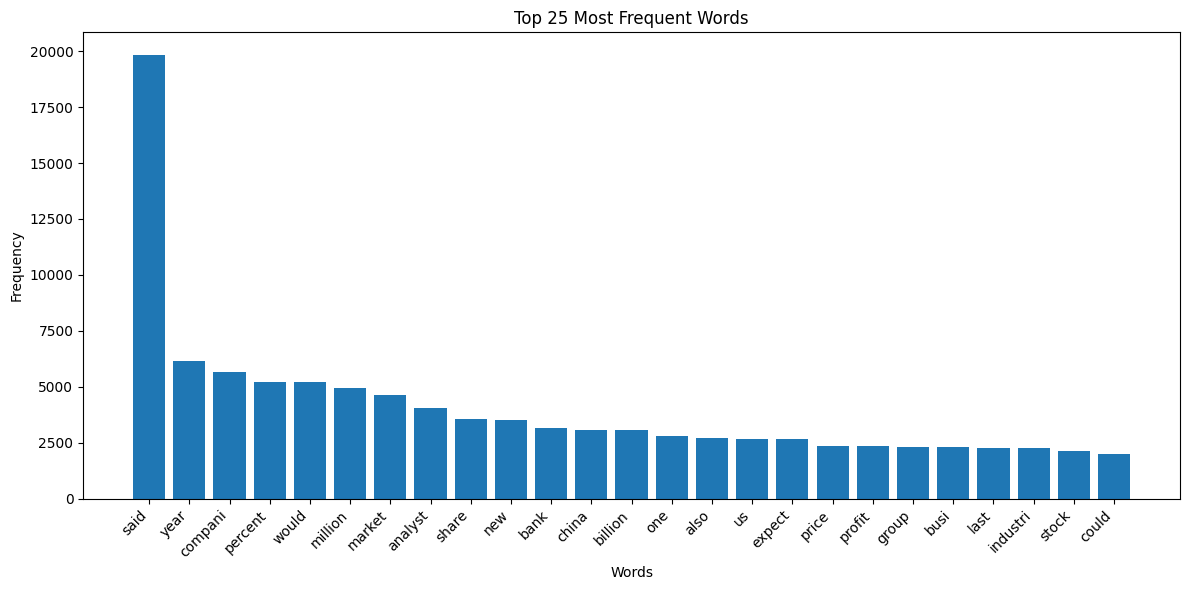

In [8]:
# histograms of word frequencies
combined_tokens = [word for sublist in df["tokenized_text_seperated"] for word in sublist]
top_n = 25
word_freq = Counter(combined_tokens)
top_words = word_freq.most_common(top_n)
plt.figure(figsize=(12, 6))
words, frequencies = zip(*top_words)
plt.bar(words, frequencies)
plt.title(f'Top {top_n} Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [9]:
# convert authors to numerical representation
unique_authors = df["author"].unique()
author_num_dict = {author: index for index, author in enumerate(unique_authors)}
encoded_df = df.copy()
encoded_df["author"] = encoded_df["author"].map(author_num_dict)

# or with this:
# le = LabelEncoder()
# df['author_encoded'] = le.fit_transform(df['author'])

In [12]:
# train model for author identification and accuracy evaluation
features = tfidf_matrix.toarray()
labels = encoded_df["author"]

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

# print("Classification Report:")
# print(classification_report(y_test, y_pred)) # target_names=author_num_dict.classes_
# Optional: Feature importance
# feature_importance = rf_classifier.feature_importances_
# feature_imp_df = pd.DataFrame({
#     'feature': feature_names,
#     'importance': feature_importance
# }).sort_values('importance', ascending=False).head(10)

# print("\nTop 10 Most Important Features:")
# print(feature_imp_df)

# # Optional: Confusion Matrix
# print("\nConfusion Matrix:")
# print(confusion_matrix(y_test, y_pred))

# # Function to predict author for new text
# def predict_author(text):
#     # Transform the input text using the same vectorizer
#     text_tfidf = vectorizer.transform([text])
#     # Predict the author
#     predicted_encoded = rf_classifier.predict(text_tfidf)
#     predicted_author = le.inverse_transform(predicted_encoded)[0]
#     return predicted_author


: 

In [ ]:
# Plot the t-SNE results
# tsne_3d = TSNE(n_components=3, random_state=42)
# tsne_results_3d = tsne_3d.fit_transform(tfidf_matrix.toarray())
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)